In [ ]:
# First cell
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 11.2 MB/s eta 0:00:00


In [ ]:
# Next cell
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import easyocr
import time
import csv
from datetime import datetime
import os
import re
import matplotlib.pyplot as plt

# Next cell
# Function to take photo using JavaScript
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
        const div = document.createElement('div');
        const video = document.createElement('video');
        const canvas = document.createElement('canvas');
        const button = document.createElement('button');
        button.textContent = 'Capture';
        document.body.appendChild(div);
        div.appendChild(video);
        div.appendChild(button);

        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        video.srcObject = stream;
        await video.play();

        // Resize the canvas to match the video's dimensions
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;

        // Capture the photo
        await new Promise((resolve) => button.onclick = resolve);
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(t => t.stop());

        const data = canvas.toDataURL('image/jpeg', quality);
        div.remove();
        return data;
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Next cell



In [ ]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Define CSV file for logging expiry dates
csv_file = 'expiry_dates.csv'

# Create the CSV file and write the header if it doesn't exist
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Serial Number', 'Expiry Date', 'Manufacturing Date', 'Time of Scan'])

# Function to extract expiry date
def find_expiry_date(detected_texts):
    expiry_keywords = ['exp', 'expiry', 'best before', 'use by', 'discard date', 'expiration date', 'use by']
    date_pattern = r'(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{1,2}\s\w{3,9}\s\d{4}|\w{3,9}\s\d{1,2},\s\d{4}|\d{4}[/-]\d{1,2}[/-]\d{1,2})'

    for text, coords in detected_texts:
        cleaned_text = re.sub(r'[^\w\s:/-]', '', text).lower()

        # Check if any expiry-related keyword exists in the text
        if any(keyword in cleaned_text for keyword in expiry_keywords):
            match = re.search(date_pattern, text)
            if match:
                return match.group(0), coords

        # Even if no keyword, check for date pattern (since dates could appear alone)
        match = re.search(date_pattern, text)
        if match:
            return match.group(0), coords

    return None, None

# Function to extract manufacturing date
def find_manufacturing_date(detected_texts):
    mfg_keywords = ['mfg', 'manufactured', 'mfg date', 'manufacturing date', 'produced on', 'date of manufacture', 'pkd']
    date_pattern = r'(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{1,2}\s\w{3,9}\s\d{4}|\w{3,9}\s\d{1,2},\s\d{4}|\d{4}[/-]\d{1,2}[/-]\d{1,2})'

    for text, coords in detected_texts:
        cleaned_text = re.sub(r'[^\w\s:/-]', '', text).lower()

        # Check if any manufacturing-related keyword exists in the text
        if any(keyword in cleaned_text for keyword in mfg_keywords):
            match = re.search(date_pattern, text)
            if match:
                return match.group(0), coords

        # Even if no keyword, check for date pattern
        match = re.search(date_pattern, text)
        if match:
            return match.group(0), coords

    return None, None

# Function to infer dates based on the rule-based strategy
def infer_dates(detected_dates):
    # Ensure we only have valid dates for comparison
    valid_dates = [d for d in detected_dates if d[0] is not None]

    if len(valid_dates) == 2:
        date1, coords1 = valid_dates[0]
        date2, coords2 = valid_dates[1]

        # Try different date formats to handle both cases
        for fmt in ('%Y-%m-%d', '%d/%m/%Y'):
            try:
                parsed_date1 = datetime.strptime(date1, fmt)
                break
            except ValueError:
                continue

        for fmt in ('%Y-%m-%d', '%d/%m/%Y'):
            try:
                parsed_date2 = datetime.strptime(date2, fmt)
                break
            except ValueError:
                continue

        # Assign the earlier date as the manufacturing date, later as the expiry date
        if parsed_date1 < parsed_date2:
            return date1, date2  # date1 is manufacturing date, date2 is expiry date
        else:
            return date2, date1  # date2 is manufacturing date, date1 is expiry date
    return None, None


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:

# Next cell
def display_image_with_annotations(img, detected_texts):
    for text, coords in detected_texts:
        if isinstance(coords, list) and len(coords) == 4:
            try:
                top_left = coords[0]
                bottom_right = coords[2]

                cv2.rectangle(img, (int(top_left[0]), int(top_left[1])),
                              (int(bottom_right[0]), int(bottom_right[1])),
                              (0, 255, 0), 2)  # Green rectangle

                cv2.putText(img, text, (int(top_left[0]), int(top_left[1])-10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Red color
            except IndexError:
                print(f"Invalid coordinates for text: {text}")
        else:
            print(f"Invalid coordinates for text: {text}")

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def process_images_from_webcam():
    image_list = []
    num_images = 3  # Number of times to capture and process images

    for i in range(num_images):
        print(f"Capturing image {i+1}...")

        # Capture an image from the webcam
        filename = take_photo(f'image_{i+1}.jpg')

        # Load the captured image using OpenCV
        img = cv2.imread(filename)

        # Perform OCR using easyocr
        result = reader.readtext(img)

        # Collect detected texts
        detected_texts = [(detection[1], detection[0]) for detection in result]

        # Debugging: Print detected texts and coordinates
        for text, coords in detected_texts:
            print(f"Detected Text: {text} at {coords}")

        # Find expiry and manufacturing dates
        detected_expiry, expiry_coords = find_expiry_date(detected_texts)
        detected_manufacturing, mfg_coords = find_manufacturing_date(detected_texts)

        # If both dates are found but no clear labels, apply rule-based strategy
        if not detected_expiry or not detected_manufacturing:
            detected_dates = [(detected_expiry, expiry_coords), (detected_manufacturing, mfg_coords)]
            detected_manufacturing, detected_expiry = infer_dates([d for d in detected_dates if d[0] is not None])

        # Print expiry and manufacturing date
        print(f"Image {i+1}:")
        print(f"Expiry Date: {detected_expiry if detected_expiry else 'Not found'}")
       # print(f"Manufacturing Date: {detected_manufacturing if detected_manufacturing else 'Not found'}")

        # Log the expiry date into CSV file
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            time_of_scan = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            writer.writerow([i+1, detected_expiry if detected_expiry else 'Not found',
                             detected_manufacturing if detected_manufacturing else 'Not found', time_of_scan])

        # Display the image with annotations
        display_image_with_annotations(img, detected_texts)

        # Wait for 10 seconds before taking the next image
        time.sleep(10)

        # Store the image and its detected data
        image_list.append((img, detected_expiry, detected_manufacturing))

    print(f"\nProcessed {len(image_list)} images in total.")
    return image_list

# Next cell


Capturing image 1...


<IPython.core.display.Javascript object>

Detected Text: Bouro at [[82, 64], [189, 64], [189, 103], [82, 103]]
Detected Text: Vica at [[107, 93], [181, 93], [181, 131], [107, 131]]
Detected Text: 25/04/25 at [[302, 117], [386, 117], [386, 158], [302, 158]]
Detected Text: 840730A4 at [[301.2802656784306, 70.38855792470427], [380.5676027209722, 65.19107467669015], [381.7197343215694, 98.61144207529573], [302.4323972790278, 104.80892532330985]]
Detected Text: 30/07/24 at [[301.13701426866953, 97.46032711047206], [382.5678803344032, 90.19162229626139], [383.86298573133047, 123.53967288952794], [302.4321196655968, 130.8083777037386]]
Image 1:
Expiry Date: 25/04/25


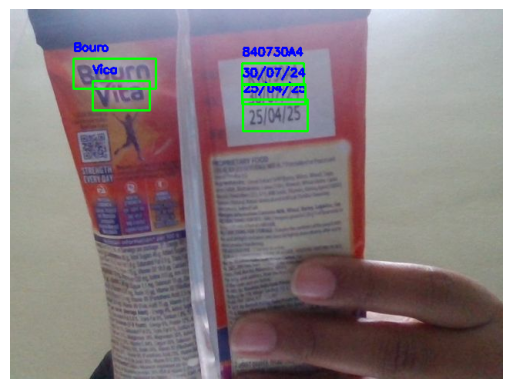

Capturing image 2...


<IPython.core.display.Javascript object>

Detected Text: Bouro at [[49, 103], [157, 103], [157, 143], [49, 143]]
Detected Text: R4072044 at [[273, 106], [354, 106], [354, 143], [273, 143]]
Detected Text: Vita at [[71, 131], [147, 131], [147, 171], [71, 171]]
Detected Text: 30/07124 at [[273, 129], [357, 129], [357, 170], [273, 170]]
Detected Text: 25/04/25 at [[274.21114561800016, 162.42229123600035], [357.55826807257415, 155.1727812600295], [359.78885438199984, 189.57770876399965], [276.44173192742585, 196.8272187399705]]
Image 2:
Expiry Date: 25/04/25


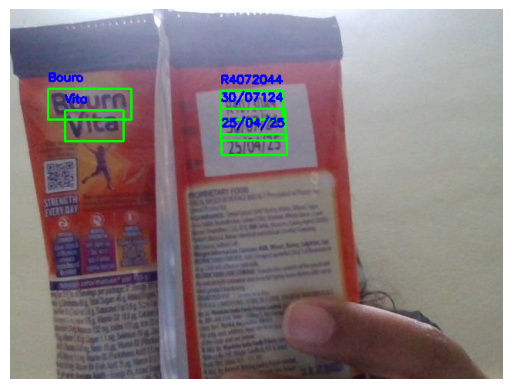

Capturing image 3...


<IPython.core.display.Javascript object>

In [ ]:
# Start the image capture and processing loop
images_with_text = process_images_from_webcam()